# DEMO Kalamn Filter and his friends 

In [ ]:
# install library
!git clone https://github.com/intsystems/Kalman-filter-and-his-friends /tmp/Kalman-filter-and-his-friends
!python3 -m pip install /tmp/Kalman-filter-and-his-friends/src/

In [1]:
import torch
import matplotlib.pyplot as plt
from kalman.gaussian import GaussianState
from kalman.extended import ExtendedKalmanFilter
from kalman.unscented import UnscentedKalmanFilter
from kalman.filters import KalmanFilter

### Example of work on some basic example

In [51]:
# ----------------------------------------------------------
#   Configuration
# ----------------------------------------------------------
dt          = 0.1                         # time step
state_dim   = 4                           # [x, y, vx, vy]
obs_dim     = 2                           # [range, bearing]
num_steps   = 100

# ----------------------------------------------------------
#   Noise statistics
# ----------------------------------------------------------
process_noise     = torch.diag(torch.tensor([0.1, 0.1, 0.5, 0.5]))**2   # Q  (4×4)
measurement_noise = torch.diag(torch.tensor([0.02, 0.02]))**2           # R  (2×2)

# ----------------------------------------------------------
#   Non‑linear process model  f(x)
# ----------------------------------------------------------
def f_cv_turn(x: torch.Tensor) -> torch.Tensor:
    """
    Constant–speed planar motion with a small deterministic turn.
    x: (..., 4)  ->  (..., 4)
    """
    x_pos, y_pos, vx, vy = torch.unbind(x, dim=-1)

    speed = torch.sqrt(vx**2 + vy**2)                 # |v|
    angle = torch.atan2(vy, vx)
    new_angle = angle + 0.1 * dt                      # small turn

    vx_new = speed * torch.cos(new_angle)
    vy_new = speed * torch.sin(new_angle)

    x_new = x_pos + vx_new * dt
    y_new = y_pos + vy_new * dt

    return torch.stack((x_new, y_new, vx_new, vy_new), dim=-1)

# ----------------------------------------------------------
# Measurement model  h(x)
# ----------------------------------------------------------
def h_polar(x: torch.Tensor) -> torch.Tensor:
    """
    Cartesian -> polar [range, bearing].
    x: (..., 4) -> (..., 2)
    """
    x_pos, y_pos = x[..., 0], x[..., 1]
    r = torch.sqrt(x_pos**2 + y_pos**2)
    theta = torch.atan2(y_pos, x_pos)
    return torch.stack((r, theta), dim=-1)


### Create Kalman Filters

In [52]:
# -----------------------------------------------------------------------
#     Build the Unscented Kalman Filter (all models + noise at once)
# -----------------------------------------------------------------------
process_matrix = torch.eye(state_dim)
process_matrix[0, 2] = dt
process_matrix[1, 3] = dt
measurement_matrix = torch.eye(obs_dim, state_dim)

kf = KalmanFilter(
    process_matrix=process_matrix,
    measurement_matrix=measurement_matrix,
    process_noise=process_noise,
    measurement_noise=measurement_noise
)

# -----------------------------------------------------------------------
#     Build the Unscented Kalman Filter (all models + noise at once)
# -----------------------------------------------------------------------
ukf = UnscentedKalmanFilter(
    state_dim = state_dim,
    obs_dim   = obs_dim,
    f         = f_cv_turn,
    h         = h_polar,
    Q         = process_noise,
    R         = measurement_noise,
    alpha=0.1, beta=2.0, kappa=0.0,
    eps=1e-7
)

# ----------------------------------------------------------
#     Build the Extended Kalman Filter (all models + noise at once)
# ----------------------------------------------------------
ekf = ExtendedKalmanFilter(
    state_dim   = state_dim,
    obs_dim     = obs_dim,
    f           = f_cv_turn,
    h           = h_polar,
    Q           = process_noise,
    R           = measurement_noise,
)

In [53]:
# ----------------------------------------------------------
#   Ground‑truth trajectory + noisy measurements
# ----------------------------------------------------------
def generate_measurements(state: torch.Tensor, num_steps: int, state_dim: int, obs_dim: int):
    """
    Generating a counterclockwise rotation of the point.
    """
    true_states      = torch.zeros(num_steps, state_dim)
    measurements     = torch.zeros(num_steps, obs_dim)
    
    for t in range(num_steps):
        # --- propagate truth with a *random* additional turn (not known to filter)
        speed       = torch.linalg.vector_norm(state[2:])
        angle       = torch.atan2(state[3], state[2])
        angle      += 0.1 * dt + 0.02 * torch.randn(())      # ~ small random perturbation
        state[2:]   = speed * torch.tensor([torch.cos(angle), torch.sin(angle)])
        state[0:2] += state[2:] * dt
        true_states[t] = state

        # --- sensor reading  z = h(x) + v
        r, theta = h_polar(state).tolist()
        measurements[t] = torch.tensor([
            r     + torch.randn(()) * measurement_noise[0, 0].sqrt(),
            theta + torch.randn(()) * measurement_noise[1, 1].sqrt()
        ])
    return measurements, true_states

In [60]:
state = torch.tensor([1.0, 0.0, 0.0, 1.0])
measurements, true_states = generate_measurements(state, num_steps, state_dim, obs_dim)
measurements_xy = torch.stack([
    measurements[:, 0] * torch.cos(measurements[:, 1]),
    measurements[:, 0] * torch.sin(measurements[:, 1])
], dim=-1)

mean  = torch.tensor([1.0, 0.0, 0.0, 1.0])
cov   = torch.diag(torch.tensor([1.0, 1.0, 1.0, 1.0]))
# ----------------------------------------------------------
#   Run the Unscented Kalman Filter
# ----------------------------------------------------------
est_means_ukf = torch.zeros(num_steps, state_dim)
est_covs_ukf  = torch.zeros(num_steps, state_dim, state_dim)
state_est    = GaussianState(mean, cov)

for t in range(num_steps):
    state_est = ukf.predict_update(state_est, measurements[t])   # <‑‑ new call
    est_means_ukf[t] = state_est.mean
    est_covs_ukf[t]  = state_est.covariance


# ----------------------------------------------------------
#   Run the Extended Kalman Filter
# ----------------------------------------------------------
est_means_ekf = torch.zeros(num_steps, state_dim)
est_covs_ekf  = torch.zeros(num_steps, state_dim, state_dim)
state_est     = GaussianState(mean, cov)

for t in range(num_steps):
    state_est = ekf.predict_update(state_est, measurements[t])   # <‑‑ new call
    est_means_ekf[t] = state_est.mean
    est_covs_ekf[t]  = state_est.covariance


# ----------------------------------------------------------
#   Run the Kalman Filter
# ----------------------------------------------------------
est_means_kf = torch.zeros(num_steps, state_dim)
est_covs_kf  = torch.zeros(num_steps, state_dim, state_dim)
state_est     = GaussianState(mean, cov)

for t in range(num_steps):
    state_est = kf.predict(state_est)
    state_est = kf.update(state_est, measurements_xy[t])
    est_means_kf[t] = state_est.mean
    est_covs_kf[t] = state_est.covariance

#### Visaulization

KF error = 0.2311863899230957
UKF error = 0.2916041910648346
EKF error = 0.14794164896011353


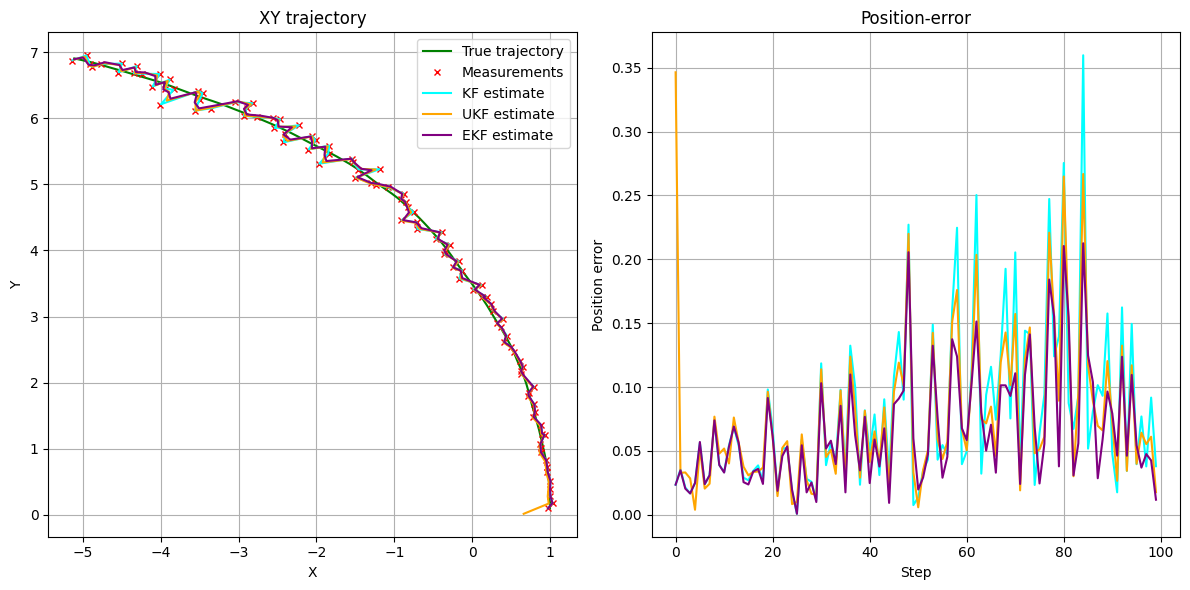

In [61]:
kf_errors_kf = torch.sqrt(torch.mean((est_means_kf - true_states)**2))
print(f"KF error = {kf_errors_kf}")
kf_errors_ukf = torch.sqrt(torch.mean((est_means_ukf - true_states)**2))
print(f"UKF error = {kf_errors_ukf}")
kf_errors_ekf = torch.sqrt(torch.mean((est_means_ekf - true_states)**2))
print(f"EKF error = {kf_errors_ekf}")

plt.figure(figsize=(12, 6))

# trajectory in XY
plt.subplot(1, 2, 1)
plt.plot(true_states[:, 0], true_states[:, 1], 'g-', label='True trajectory')
plt.plot(measurements[:, 0] * torch.cos(measurements[:, 1]),
         measurements[:, 0] * torch.sin(measurements[:, 1]),
         'rx', ms=4, label='Measurements')
plt.plot(est_means_kf[:, 0], est_means_kf[:, 1], color='cyan', linestyle='-', label='KF estimate')
plt.plot(est_means_ukf[:, 0], est_means_ukf[:, 1], color='orange', linestyle='-', label='UKF estimate')
plt.plot(est_means_ekf[:, 0], est_means_ekf[:, 1], color='purple', linestyle='-', label='EKF estimate')
plt.xlabel('X'); plt.ylabel('Y'); plt.title('XY trajectory')
plt.legend(); plt.grid(True)

# position‑error curve
position_err_kf = torch.sqrt(
    (est_means_kf[:, 0] - true_states[:, 0]) ** 2 +
    (est_means_kf[:, 1] - true_states[:, 1]) ** 2
)
position_err_ukf = torch.sqrt(
    (est_means_ukf[:, 0] - true_states[:, 0]) ** 2 +
    (est_means_ukf[:, 1] - true_states[:, 1]) ** 2
)
position_err_ekf = torch.sqrt(
    (est_means_ekf[:, 0] - true_states[:, 0]) ** 2 +
    (est_means_ekf[:, 1] - true_states[:, 1]) ** 2
)
plt.subplot(1, 2, 2)
plt.plot(position_err_kf, color='cyan', linestyle='-')
plt.plot(position_err_ukf, color='orange', linestyle='-')
plt.plot(position_err_ekf, color='purple', linestyle='-',)
plt.xlabel('Step'); plt.ylabel('Position error'); plt.title('Position‑error')
plt.grid(True)

plt.tight_layout(); plt.show()


### More detail visualization

KF error = 0.2311863899230957
UKF error = 0.2916041910648346
EKF error = 0.14794164896011353


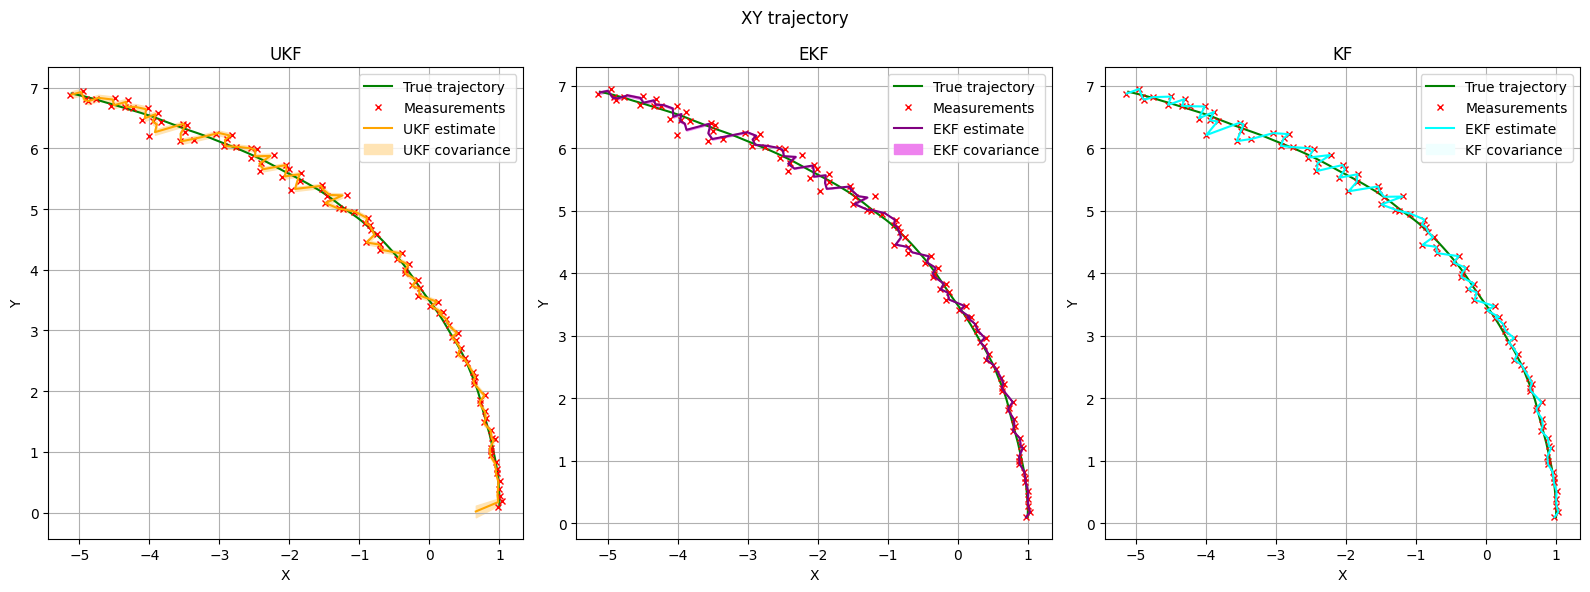

In [74]:
kf_errors_kf = torch.sqrt(torch.mean((est_means_kf - true_states)**2))
print(f"KF error = {kf_errors_kf}")
kf_errors_ukf = torch.sqrt(torch.mean((est_means_ukf - true_states)**2))
print(f"UKF error = {kf_errors_ukf}")
kf_errors_ekf = torch.sqrt(torch.mean((est_means_ekf - true_states)**2))
print(f"EKF error = {kf_errors_ekf}")

plt.figure(figsize=(16, 6))
plt.suptitle('XY trajectory')
# trajectory in XY
plt.subplot(1, 3, 1)
plt.plot(true_states[:, 0], true_states[:, 1], 'g-', label='True trajectory')
plt.plot(measurements[:, 0] * torch.cos(measurements[:, 1]),measurements[:, 0] * torch.sin(measurements[:, 1]),'rx', ms=4, label='Measurements')
plt.plot(est_means_ukf[:, 0], est_means_ukf[:, 1], color='orange', linestyle='-', label='UKF estimate')
plt.fill_between(est_means_ukf[:, 0], 
                 est_means_ukf[:, 1] - 3*est_covs_ukf[:, 1, 1],
                 est_means_ukf[:, 1] + 3*est_covs_ukf[:, 1, 1], color='moccasin', linestyle='-', label='UKF covariance')
plt.xlabel('X'); plt.ylabel('Y'); plt.title('UKF')
plt.legend(); plt.grid(True)


plt.subplot(1, 3, 2)
plt.plot(true_states[:, 0], true_states[:, 1], 'g-', label='True trajectory')
plt.plot(measurements[:, 0] * torch.cos(measurements[:, 1]),measurements[:, 0] * torch.sin(measurements[:, 1]),'rx', ms=4, label='Measurements')
plt.plot(est_means_ekf[:, 0], est_means_ekf[:, 1], color='purple', linestyle='-', label='EKF estimate')
plt.fill_between(est_means_ekf[:, 0], 
                 est_means_ekf[:, 1] - 3*est_covs_ekf[:, 1, 1],
                 est_means_ekf[:, 1] + 3*est_covs_ekf[:, 1, 1], color='violet', label='EKF covariance')
plt.xlabel('X'); plt.ylabel('Y'); plt.title('EKF')
plt.legend(); plt.grid(True)


plt.subplot(1, 3, 3)
plt.plot(true_states[:, 0], true_states[:, 1], 'g-', label='True trajectory')
plt.plot(measurements[:, 0] * torch.cos(measurements[:, 1]), measurements[:, 0] * torch.sin(measurements[:, 1]),'rx', ms=4, label='Measurements')
plt.plot(est_means_kf[:, 0], est_means_kf[:, 1], color='cyan', linestyle='-', label='EKF estimate')
plt.fill_between(est_means_kf[:, 0], 
                 est_means_kf[:, 1] - 3*est_covs_kf[:, 1, 1],
                 est_means_kf[:, 1] + 3*est_covs_kf[:, 1, 1], color='azure', linestyle='-', label='KF covariance')
plt.xlabel('X'); plt.ylabel('Y'); plt.title('KF')
plt.legend(); plt.grid(True)


plt.grid(True)
plt.tight_layout()
plt.show()

### Run forward pass

In [8]:
mean  = torch.tensor([1.0, 0.0, 0.0, 1.0])
cov   = torch.diag(torch.tensor([1.0, 1.0, 1.0, 1.0]))
# -----------------------------------------------------------------------
#     Build the Unscented Kalman Filter (all models + noise at once)
# -----------------------------------------------------------------------
ukf = UnscentedKalmanFilter(
    state_dim = state_dim,
    obs_dim   = obs_dim,
    f         = f_cv_turn,
    h         = h_polar,
    Q         = process_noise,
    R         = measurement_noise,
    alpha=0.1, beta=2.0, kappa=0.0,
    init_mean=mean,
    init_cov=cov,
    eps=1e-7
)
# ----------------------------------------------------------
#     Build the Extended Kalman Filter (all models + noise at once)
# ----------------------------------------------------------
ekf = ExtendedKalmanFilter(
    state_dim   = state_dim,
    obs_dim     = obs_dim,
    f           = f_cv_turn,
    h           = h_polar,
    Q           = process_noise,
    R           = measurement_noise,
    init_mean=mean,
    init_cov=cov,
)

#### Forward pass mode

In [9]:
states_ekf = ekf.forward(measurements)
est_means_ekf = states_ekf.mean
est_covs_ekf  = states_ekf.covariance

states_ukf = ukf.forward(measurements)
est_means_ukf = states_ukf.mean
est_covs_ukf = states_ukf.covariance

#### Visualization

UKF error = 0.28801387548446655
EKF error = 0.14546015858650208


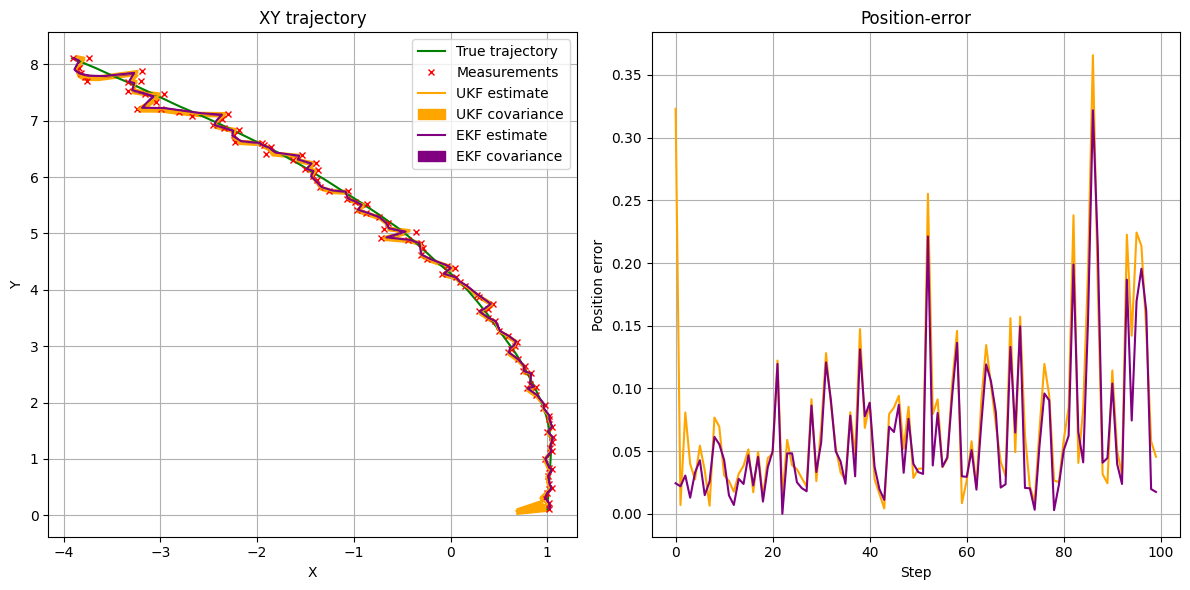

In [10]:
kf_errors_ukf = torch.sqrt(torch.mean((est_means_ukf - true_states)**2))
print(f"UKF error = {kf_errors_ukf}")
kf_errors_ekf = torch.sqrt(torch.mean((est_means_ekf - true_states)**2))
print(f"EKF error = {kf_errors_ekf}")

plt.figure(figsize=(12, 6))
# trajectory in XY
plt.subplot(1, 2, 1)
plt.plot(true_states[:, 0], true_states[:, 1], 'g-', label='True trajectory')
plt.plot(measurements[:, 0] * torch.cos(measurements[:, 1]),measurements[:, 0] * torch.sin(measurements[:, 1]),'rx', ms=4, label='Measurements')
plt.plot(est_means_ukf[:, 0], est_means_ukf[:, 1], color='orange', linestyle='-', label='UKF estimate')
plt.fill_between(est_means_ukf[:, 0], 
                 est_means_ukf[:, 1] - 3*est_covs_ukf[:, 1, 1],
                 est_means_ukf[:, 1] + 3*est_covs_ukf[:, 1, 1], color='orange', linestyle='-', label='UKF covariance')
plt.plot(est_means_ekf[:, 0], est_means_ekf[:, 1], color='purple', linestyle='-', label='EKF estimate')
plt.fill_between(est_means_ekf[:, 0], 
                 est_means_ekf[:, 1] - 3*est_covs_ekf[:, 1, 1],
                 est_means_ekf[:, 1] + 3*est_covs_ekf[:, 1, 1], color='purple', linestyle='-', label='EKF covariance')
plt.xlabel('X'); plt.ylabel('Y'); plt.title('XY trajectory')
plt.legend(); plt.grid(True)

position_err_ukf = torch.sqrt(
    (est_means_ukf[:, 0] - true_states[:, 0]) ** 2 +
    (est_means_ukf[:, 1] - true_states[:, 1]) ** 2
)
position_err_ekf = torch.sqrt(
    (est_means_ekf[:, 0] - true_states[:, 0]) ** 2 +
    (est_means_ekf[:, 1] - true_states[:, 1]) ** 2
)
plt.subplot(1, 2, 2)
plt.plot(position_err_ukf, color='orange', linestyle='-')
plt.plot(position_err_ekf, color='purple', linestyle='-',)
plt.xlabel('Step'); plt.ylabel('Position error'); plt.title('Position‑error')
plt.grid(True)

plt.tight_layout(); plt.show()

### Variational Kalman Filter

In [34]:
from kalman.vkf import VBKalmanFilter
import numpy as np

In [32]:
state_dim = 2  
obs_dim = 1

F = torch.eye(state_dim)
H = torch.tensor([[1., 0.]])
Q = 0.1 * torch.eye(state_dim)
R_init = torch.eye(obs_dim) * 0.5

vkf = VBKalmanFilter(
    process_matrix=F,
    measurement_matrix=H,
    process_noise=Q,
    initial_measurement_cov=R_init,
    rho=0.95
)

T = 100
B = 1

true_states = torch.zeros(T, state_dim)
true_states[:, 0] = torch.linspace(0, 10, T)
true_states[:, 1] = 0.5


observations = true_states[:, :1] + torch.randn(T, obs_dim) * 0.8
observations = observations.unsqueeze(1).repeat(1, B, 1)

with torch.no_grad():
    means, covs = vkf(observations)
    current_R = vkf.get_measurement_covariance()


VKF error = 0.14546015858650208


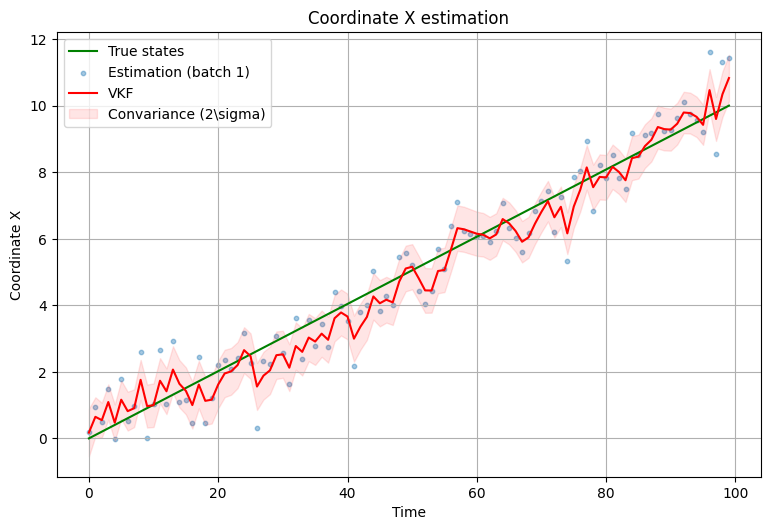

In [36]:
kf_errors_vkf = torch.sqrt(torch.mean((means - true_states)**2))
print(f"VKF error = {kf_errors_ekf}")
plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
plt.title("Coordinate X estimation")
plt.plot(true_states[:, 0].numpy(), 'g-', label='True states')
for b in range(B):
    plt.scatter(range(T), observations[:, b, 0].numpy(), 
                s=10, alpha=0.4, label=f'Estimation (batch {b+1})')
plt.plot(means[:, 0, 0].numpy(), 'r-', label='VKF')
plt.fill_between(
    range(T),
    means[:, 0, 0].numpy() - 2 * np.sqrt(covs[:, 0, 0, 0].numpy()),
    means[:, 0, 0].numpy() + 2 * np.sqrt(covs[:, 0, 0, 0].numpy()),
    color='r', alpha=0.1, label=r'Convariance (2\sigma)'
)
plt.xlabel("Time")
plt.ylabel("Coordinate X")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()